# Graded Challenge 4 - Phase 1 - FTDS (Offline)

## I. Introduction


- Peter Zultan
- HCK-001
- Objective: Create clustering model for Customer Segmentation from bank credit card. This data was information about credit card usage last 6 months.

## II. QUERY
SELECT
  *
FROM
  `ftds-hacktiv8-project.phase1_ftds_001_hck.credit-card-information`
where mod(CUST_ID, 2) <>0

## III. Import Libraries

In [305]:
import phik
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings('ignore')

#check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#for preprocessing
from sklearn.model_selection import train_test_split

#for Handling Outliers
from feature_engine.outliers import Winsorizer

#for scaling
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer

#import model
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

#import model evaluation
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

## IV. Data Loading

In [306]:
df = pd.read_csv('h8dsft_P1G4_PeterZ.csv')
df.head(3) #top three data

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,3091,3.833185,0.125,45.00,45.00,0.0,0.0,0.125,0.125,0.0,0.0,0,1,500.0,0.000000,NaN,0.0,8
1,5069,0.000000,0.000,176.03,176.03,0.0,0.0,0.125,0.125,0.0,0.0,0,1,7000.0,0.000000,NaN,0.0,8
2,6075,757.964752,0.875,157.40,157.40,0.0,0.0,0.125,0.125,0.0,0.0,0,6,1200.0,1494.480376,2638.59841,0.0,8


In [307]:
df.tail(3) #bottom three data

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4472,7347,1322.818587,1.0,0.0,0.0,0.0,762.301096,0.000000,0.000000,0.0,0.545455,11,0,1500.0,1035.627320,312.835530,0.0,11
4473,8447,1060.391273,1.0,0.0,0.0,0.0,1475.858013,0.000000,0.000000,0.0,0.545455,10,0,2000.0,407.360560,277.084736,0.0,11
4474,1995,3447.674222,1.0,205.0,205.0,0.0,4548.057776,0.090909,0.090909,0.0,0.545455,7,1,10500.0,665.239171,817.844662,0.0,11


## V. Exploratory Data Analysis (EDA)

In [308]:
dfcopy = df.copy() #make a copy data

In [309]:
dfcopy.isnull().sum() #check null values in data

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    155
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

There are 155 null values at `MINIMUM_PAYMENTS` in the dataset

In [310]:
dfcopy.dropna(axis = 0, inplace= True)
dfcopy.reset_index(drop=True, inplace=True)

In [311]:
dfcopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4320 non-null   int64  
 1   BALANCE                           4320 non-null   float64
 2   BALANCE_FREQUENCY                 4320 non-null   float64
 3   PURCHASES                         4320 non-null   float64
 4   ONEOFF_PURCHASES                  4320 non-null   float64
 5   INSTALLMENTS_PURCHASES            4320 non-null   float64
 6   CASH_ADVANCE                      4320 non-null   float64
 7   PURCHASES_FREQUENCY               4320 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4320 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4320 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4320 non-null   float64
 11  CASH_ADVANCE_TRX                  4320 non-null   int64  
 12  PURCHA

No missing values and all datatypes are correct.

In [312]:
dfcopy.duplicated(keep=False) #check duplicated data

0       False
1       False
2       False
3       False
4       False
        ...  
4315    False
4316    False
4317    False
4318    False
4319    False
Length: 4320, dtype: bool

There are no duplicated data in dataset.

In [313]:
#small case columns name
dfcopy.columns = map(str.lower, dfcopy.columns)
dfcopy.columns

Index(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure'],
      dtype='object')

In [314]:
dfcopy

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,6075,757.964752,0.875,157.4,157.4,0.0,0.000000,0.125000,0.125000,0.0,0.000000,0,6,1200.0,1494.480376,2638.598410,0.0,8
1,6291,264.566591,0.375,1150.0,1150.0,0.0,0.000000,0.125000,0.125000,0.0,0.000000,0,1,1200.0,3029.380326,85.428885,0.0,8
2,7755,440.613643,1.000,600.0,600.0,0.0,0.000000,0.125000,0.125000,0.0,0.000000,0,1,1000.0,215.316424,137.846006,0.0,8
3,8299,611.561026,1.000,765.0,765.0,0.0,0.000000,0.125000,0.125000,0.0,0.000000,0,1,2000.0,204.464151,146.352314,0.0,8
4,8805,105.333584,0.375,306.0,306.0,0.0,0.000000,0.125000,0.125000,0.0,0.000000,0,2,6000.0,101.986927,118.324082,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2345,9629.808851,1.000,0.0,0.0,0.0,4372.393835,0.000000,0.000000,0.0,0.545455,9,0,12000.0,2468.988022,2134.295731,0.0,11
4316,6785,1040.030221,1.000,0.0,0.0,0.0,1390.648290,0.000000,0.000000,0.0,0.545455,18,0,1400.0,290.129620,287.994171,0.0,11
4317,7347,1322.818587,1.000,0.0,0.0,0.0,762.301096,0.000000,0.000000,0.0,0.545455,11,0,1500.0,1035.627320,312.835530,0.0,11
4318,8447,1060.391273,1.000,0.0,0.0,0.0,1475.858013,0.000000,0.000000,0.0,0.545455,10,0,2000.0,407.360560,277.084736,0.0,11


Skweness value:  1.487940822693631
Mean value 4519.752747381249
Median value 3000.0


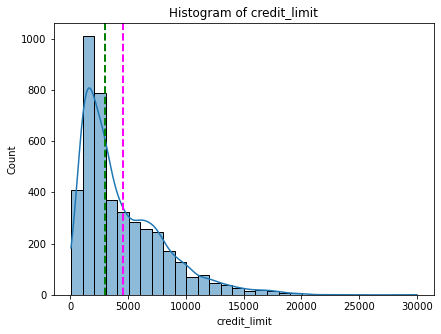

In [315]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(dfcopy['credit_limit'], bins=30, kde=True)
plt.axvline(dfcopy['credit_limit'].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(dfcopy['credit_limit'].median(), color='green', linestyle='dashed', linewidth=2)
plt.title('Histogram of credit_limit')

print('Skweness value: ', dfcopy['credit_limit'].skew())
print('Mean value', dfcopy['credit_limit'].mean())
print('Median value', dfcopy['credit_limit'].median())

credit limit data is skewed, median is taken as central tendency.

<AxesSubplot:xlabel='oneoff_purchases_frequency', ylabel='Count'>

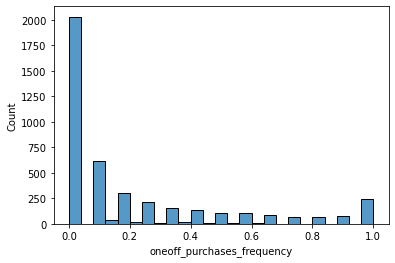

In [316]:
sns.histplot(data=dfcopy['oneoff_purchases_frequency'])

Most of the customer seldom use maximum purchases amount done in one-go

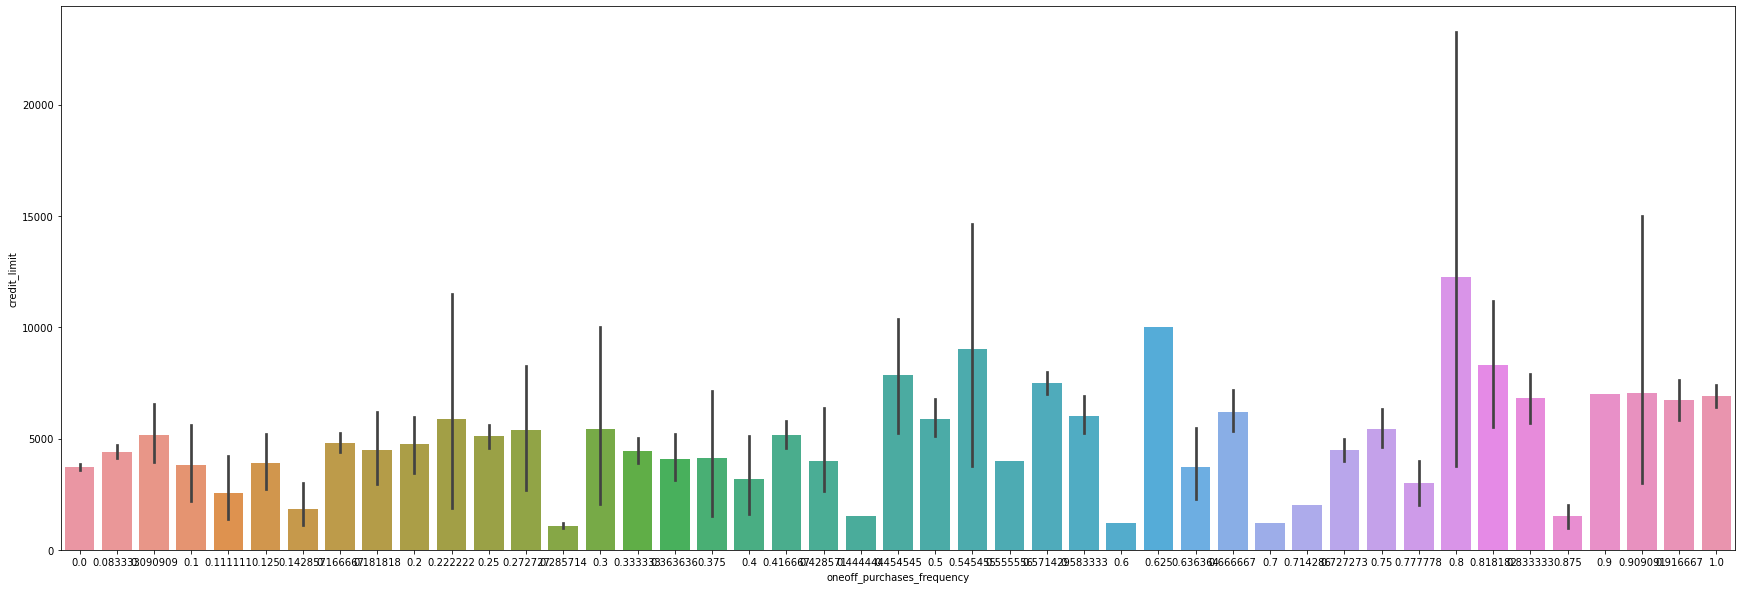

In [317]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=dfcopy, x='oneoff_purchases_frequency', y='credit_limit')
plt.show()

Bigger credit limit customers have tendency to use one off purchases.

In [318]:
dfcopy['balance'].sort_values(ascending=True)

1517        0.000000
1137        0.000000
1215        0.000199
2961        0.001146
2919        0.001214
            ...     
4087    14581.459140
3056    15244.748650
2484    15532.339720
4054    16115.596400
476     18495.558550
Name: balance, Length: 4320, dtype: float64

<AxesSubplot:xlabel='balance', ylabel='Count'>

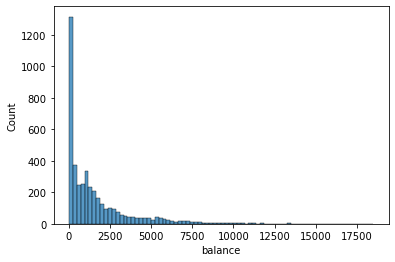

In [319]:
sns.histplot(data=dfcopy['balance'])

There are lot of customer with 0 balance mean most of them use credit card till empty.

## VI. Data Preprocessing

### a. Split Data

In [320]:
train, inf = train_test_split(dfcopy, test_size = 0.12, random_state=1)

interval columns not set, guessing: ['cust_id', 'balance', 'balance_frequency', 'purchases', 'oneoff_purchases', 'installments_purchases', 'cash_advance', 'purchases_frequency', 'oneoff_purchases_frequency', 'purchases_installments_frequency', 'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment', 'tenure']


<AxesSubplot:>

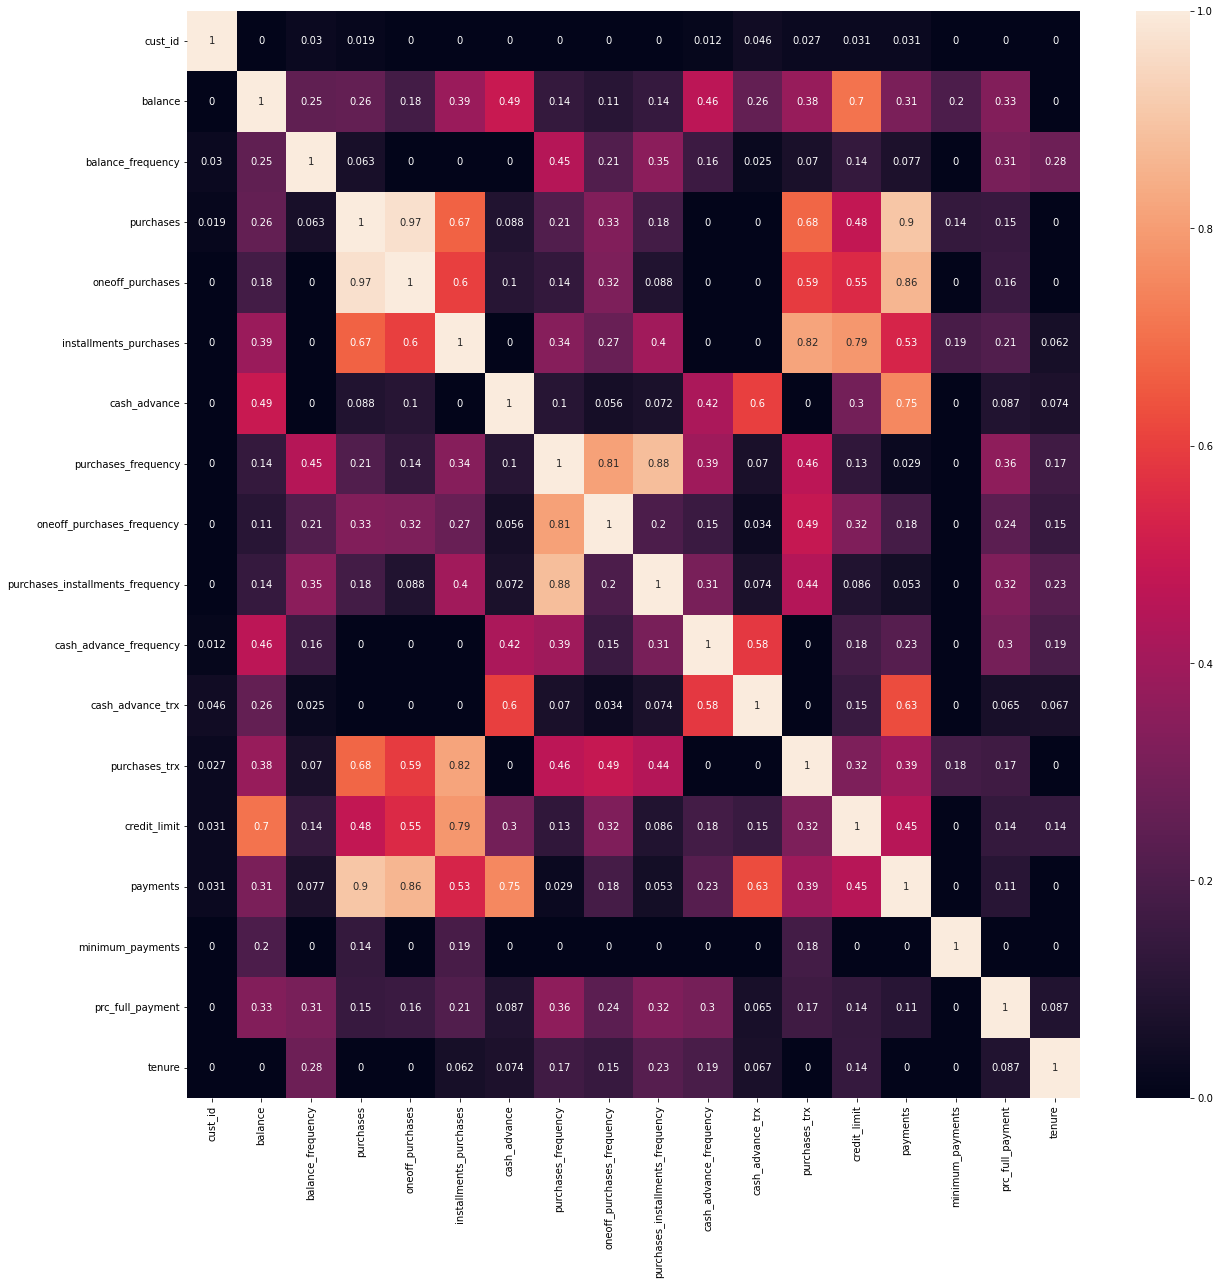

In [321]:
# of Phik Matrix.
plt.figure(figsize=(20, 20))
sns.heatmap(train.phik_matrix(), vmin = 0, vmax = 1, annot = True)

- Very high correlation (0.9 - 1) are found in `oneoff_purchases` with `purchases`, `purchases` with `payments`
- High correlation (0.7 - 0.9) are found in:
    1. `balance` with `credit_limit`.
    2. `oneoff_purchases` with `payments`.
    3. `installments_purchases` with `purchases_trx` and `credit_limit`.
    4. `cash_advance` with `payments`.
    5. `purchases_frequency` with `oneoff_purchases_frequency` and `purchases_installment_frequency`.
- Moderate correlation (0.5 - 0.7) are found in:
    1. `purchases` with `installments_purchases`, and `purchases_trx`.
    2. `oneoff_purchases` with `installments_purchases`, `purchases_trx` and `credit_limit`.
    3. `installments_purchases` with `payments`.
    4. `cash_advance` with `cash_advance_trx`.
    5. `cash_advance_frequency` with `cash_advance_trx`.
- Low correlation (0.3 - 0.5) are found in:
    1. `balance` with `installment_purchases`, `cash_advance`, `cash_advance_frequency`, `purchases_trx`, `payments`, and `prc_full_payment`.
    2. `balance_frequency` with `purchases_frequency`, `purchases_installment_frequency`, and `prc_full_payment`.
    3. `purchases` with `oneoff_purchase_frequency`.
    4. `installment_purchases` with `purchases_frequency`, `purchases_installment_frequency`.
    5. `cash_advance` with `cash_advance_frequency`, `credit_limit`.
    6. `purchases_frequency` with `cash_advance_frequency`, and `purchases_trx`.
    7. `oneoff_purchases_frequency` with `purchases`, `oneoff_purchases`, `purchases_trx`.
    8. `purchases_installments_frequency` with `cash_advance_frequency` and `purchases_trx`.

The features with very high correlation and high correlation will probably be dropped when PCA processing.

In [322]:
train.columns

Index(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure'],
      dtype='object')

In [323]:
#check multicollinearity between selected features engineering
s = train[['balance', 'balance_frequency', 'purchases','oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency','purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments','minimum_payments', 'prc_full_payment', 'tenure']]

vif=pd.DataFrame()
vif['features'] = s.columns
vif['VIF'] = [variance_inflation_factor(s, i) for i in range(s.shape[1])]

vif

,features,VIF
0,balance,4.238493
1,balance_frequency,22.621961
2,purchases,43914.182803
3,oneoff_purchases,24280.052133
4,installments_purchases,8550.573830
5,cash_advance,3.635639
6,purchases_frequency,27.108316
7,oneoff_purchases_frequency,5.863388
8,purchases_installments_frequency,17.422863
9,cash_advance_frequency,4.694521


From vif test, `balance_frequency`, `purchases`, `oneoff_purchases`, `installment_purchases`, `purchases_frequency`, `purchases_installments_frequency`, and `tenure`.

### b. Handling Outliers
https://link.springer.com/referenceworkentry/10.1007/978-0-387-30164-8_426#:~:text=The%20K%2Dmeans%20clustering%20algorithm,robust%20to%20noises%20and%20outliers.

In [324]:
train

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
3723,6265,764.042156,0.818182,0.00,0.00,0.0,1307.102516,0.000000,0.000000,0.000000,0.166667,3,0,7500.000000,1566.806897,172.959728,0.000000,12
1125,579,4181.216991,1.000000,1443.33,1443.33,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,6000.000000,1027.149996,1420.666789,0.000000,12
2000,4909,1981.929376,1.000000,145.80,0.00,145.8,0.000000,0.833333,0.000000,0.750000,0.000000,0,10,6000.000000,2803.926679,467.477726,0.083333,12
4085,1861,1817.150299,1.000000,596.50,0.00,596.5,1736.759805,0.833333,0.000000,0.833333,0.583333,11,10,3000.000000,891.637597,474.182947,0.000000,12
2811,1941,1360.742377,1.000000,0.00,0.00,0.0,1481.587093,0.000000,0.000000,0.000000,0.083333,1,0,1500.000000,378.294227,321.354137,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,4931,1988.595057,1.000000,0.00,0.00,0.0,49.912460,0.000000,0.000000,0.000000,0.083333,1,0,2000.000000,485.111127,846.157055,0.000000,12
2763,1611,1245.654818,0.714286,626.56,626.56,0.0,1658.285219,0.428571,0.428571,0.000000,0.285714,6,8,2500.000000,249.873228,274.369204,0.000000,7
905,7043,1621.345326,1.000000,5167.60,4246.50,921.1,0.000000,1.000000,1.000000,0.833333,0.000000,0,52,5000.000000,2721.870415,523.348392,0.000000,12
3980,4011,1060.010246,1.000000,0.00,0.00,0.0,78.971459,0.000000,0.000000,0.000000,0.100000,1,0,1200.000000,233.545790,257.022991,0.000000,10


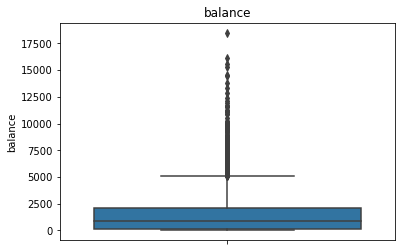

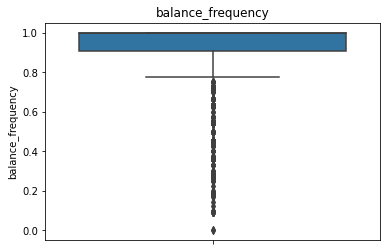

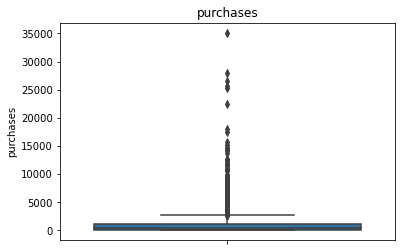

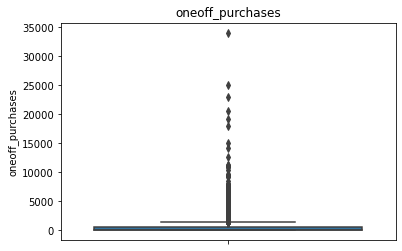

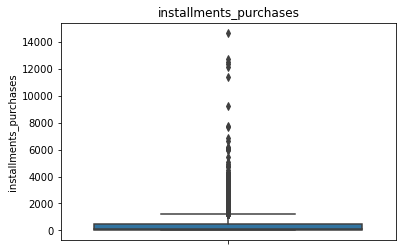

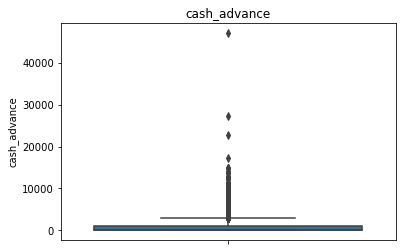

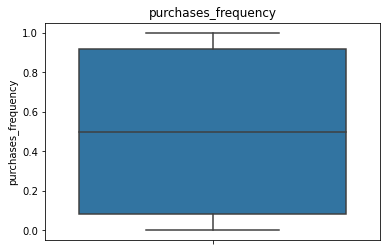

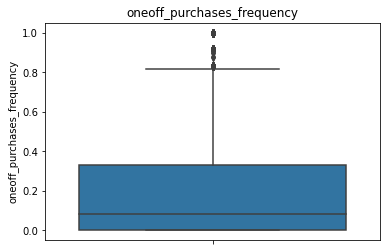

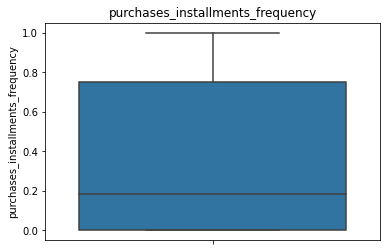

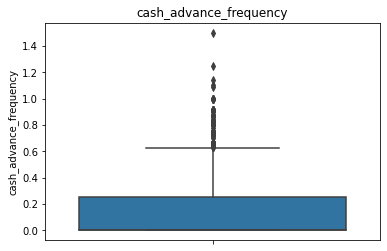

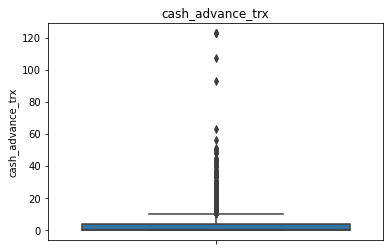

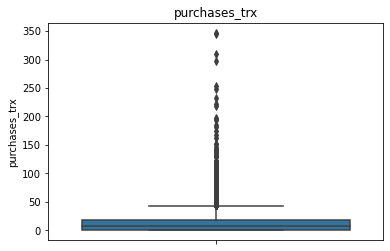

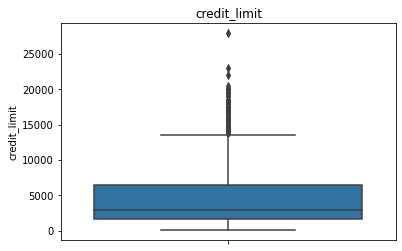

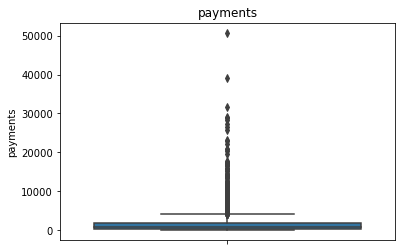

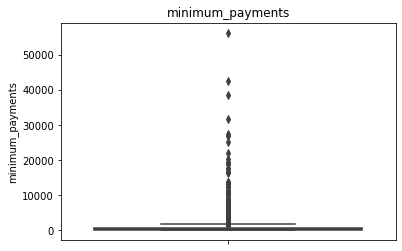

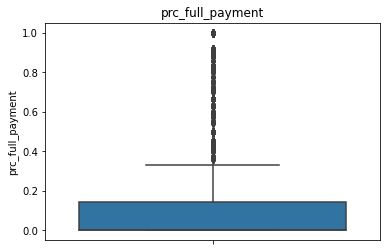

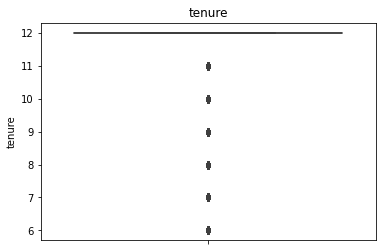

In [325]:
cols = ['balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure']

i = 0

for i in cols:
    sns.boxplot(y = train[i])
    plt.title(i)

    plt.show()

In [326]:
train_copy=train.copy()

In [327]:
train_copy.drop(columns=['cust_id'],inplace=True)

In [328]:
#capping columns with outliers
for i in cols:
    winsorize = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                            tail = 'both', # cap left, right or both tails 
                            fold = 1.5,
                            variables=[i])
    winsorize.fit(train_copy)
    df_model = winsorize.transform(train_copy)

In [329]:
df_model.describe()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
count,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.0
mean,1597.296610,0.895149,1014.918482,596.414899,418.772912,997.912141,0.498448,0.205850,0.370967,0.139330,3.407524,15.304394,4501.757924,1774.965455,858.421580,0.154578,12.0
std,2069.189865,0.209212,1989.219288,1549.250940,893.516139,2086.355265,0.403198,0.299395,0.398923,0.203493,7.382157,25.746695,3613.131157,2792.878122,2195.960776,0.292047,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.049513,0.019163,0.000000,12.0
25%,144.845309,0.909091,40.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1700.000000,415.322291,169.332847,0.000000,12.0
50%,915.857804,1.000000,374.810000,46.000000,94.980000,0.000000,0.500000,0.083333,0.181818,0.000000,0.000000,8.000000,3000.000000,922.337660,315.469998,0.000000,12.0
75%,2124.826298,1.000000,1145.850000,574.330000,476.160000,1160.459619,0.916667,0.333333,0.750000,0.250000,4.000000,18.000000,6500.000000,1924.736890,828.745267,0.142857,12.0
max,18495.558550,1.000000,35131.160000,34087.730000,14686.100000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,347.000000,28000.000000,50721.483360,56370.041170,1.000000,12.0


### Feature Scaling
https://s3.amazonaws.com/assets.datacamp.com/production/course_10628/slides/chapter3.pdf

In [330]:
#scaling using power transformer because boxcox isn't suitable 0 values
pt = PowerTransformer()
df_scaled = pt.fit_transform(train_copy)
df_scaled = pd.DataFrame(df_scaled)
df_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.036663,-1.278539,-1.504763,-1.021813,-1.092513,1.067840,-1.281866,-0.918966,-1.012774,0.706547,0.847834,-1.389833,1.009163,0.447755,-0.622946,-0.685519,0.418457
1,1.257813,0.609338,0.841421,1.210522,-1.092513,-0.958086,-1.030873,-0.117066,-1.012774,-0.893049,-0.917333,-0.885836,0.722770,0.082976,1.108268,-0.685519,0.418457
2,0.671190,0.609338,-0.222937,-1.021813,0.501775,-0.958086,0.849770,-0.918966,1.047710,-0.893049,-0.917333,0.345588,0.722770,0.959961,0.208713,0.383701,0.418457
3,0.608379,0.609338,0.380966,-1.021813,0.971756,1.128304,0.849770,-0.918966,1.164681,1.695008,1.468686,0.345588,-0.139759,-0.037972,0.220443,-0.685519,0.418457
4,0.406623,0.609338,-1.504763,-1.021813,-1.092513,1.094650,-1.281866,-0.918966,-1.012774,0.101437,0.159021,-1.389833,-0.962685,-0.757225,-0.101868,-0.685519,0.418457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,0.673641,0.609338,-1.504763,-1.021813,-1.092513,0.280416,-1.281866,-0.918966,-1.012774,0.101437,0.159021,-1.389833,-0.625837,-0.551009,0.692937,-0.685519,0.418457
3797,0.347228,-1.681805,0.404800,0.991155,-1.092513,1.118551,-0.094526,1.258075,-1.012774,1.207214,1.218287,0.201231,-0.359985,-1.096660,-0.233925,-0.685519,-2.553911
3798,0.527482,0.609338,1.641097,1.482139,1.119002,-0.958086,1.203440,1.729467,1.164681,-0.893049,-0.917333,1.471242,0.491958,0.933554,0.301553,-0.685519,0.418457
3799,0.241379,0.609338,-1.504763,-1.021813,-1.092513,0.401377,-1.281866,-0.918966,-1.012774,0.246762,0.159021,-1.389833,-1.219457,-1.151439,-0.288669,-0.685519,-2.460129


Data has been scaled but column names are in number

In [331]:
df_scaled.columns.values[0:17]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [332]:
cols

['balance',
 'balance_frequency',
 'purchases',
 'oneoff_purchases',
 'installments_purchases',
 'cash_advance',
 'purchases_frequency',
 'oneoff_purchases_frequency',
 'purchases_installments_frequency',
 'cash_advance_frequency',
 'cash_advance_trx',
 'purchases_trx',
 'credit_limit',
 'payments',
 'minimum_payments',
 'prc_full_payment',
 'tenure']

In [333]:
#rename df_scaled columns name
old_name = [0, 1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14,15,16]
df_scaled.rename(columns=(dict(zip(old_name, cols))),inplace=True)

In [334]:
df_scaled

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,0.036663,-1.278539,-1.504763,-1.021813,-1.092513,1.067840,-1.281866,-0.918966,-1.012774,0.706547,0.847834,-1.389833,1.009163,0.447755,-0.622946,-0.685519,0.418457
1,1.257813,0.609338,0.841421,1.210522,-1.092513,-0.958086,-1.030873,-0.117066,-1.012774,-0.893049,-0.917333,-0.885836,0.722770,0.082976,1.108268,-0.685519,0.418457
2,0.671190,0.609338,-0.222937,-1.021813,0.501775,-0.958086,0.849770,-0.918966,1.047710,-0.893049,-0.917333,0.345588,0.722770,0.959961,0.208713,0.383701,0.418457
3,0.608379,0.609338,0.380966,-1.021813,0.971756,1.128304,0.849770,-0.918966,1.164681,1.695008,1.468686,0.345588,-0.139759,-0.037972,0.220443,-0.685519,0.418457
4,0.406623,0.609338,-1.504763,-1.021813,-1.092513,1.094650,-1.281866,-0.918966,-1.012774,0.101437,0.159021,-1.389833,-0.962685,-0.757225,-0.101868,-0.685519,0.418457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,0.673641,0.609338,-1.504763,-1.021813,-1.092513,0.280416,-1.281866,-0.918966,-1.012774,0.101437,0.159021,-1.389833,-0.625837,-0.551009,0.692937,-0.685519,0.418457
3797,0.347228,-1.681805,0.404800,0.991155,-1.092513,1.118551,-0.094526,1.258075,-1.012774,1.207214,1.218287,0.201231,-0.359985,-1.096660,-0.233925,-0.685519,-2.553911
3798,0.527482,0.609338,1.641097,1.482139,1.119002,-0.958086,1.203440,1.729467,1.164681,-0.893049,-0.917333,1.471242,0.491958,0.933554,0.301553,-0.685519,0.418457
3799,0.241379,0.609338,-1.504763,-1.021813,-1.092513,0.401377,-1.281866,-0.918966,-1.012774,0.246762,0.159021,-1.389833,-1.219457,-1.151439,-0.288669,-0.685519,-2.460129


### PCA

In [335]:
#first PCA
pca = PCA(n_components= 17)
pca_scaled = pca.fit(df_scaled)

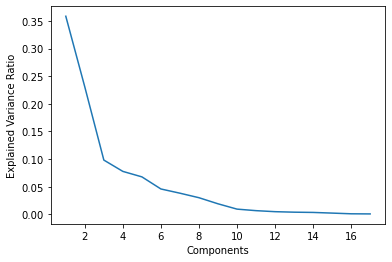

In [336]:
fig,ax=plt.subplots()
ax.plot(range(1,18),pca_scaled.explained_variance_ratio_)
ax.set_xlabel('Components')
ax.set_ylabel('Explained Variance Ratio')

plt.show()

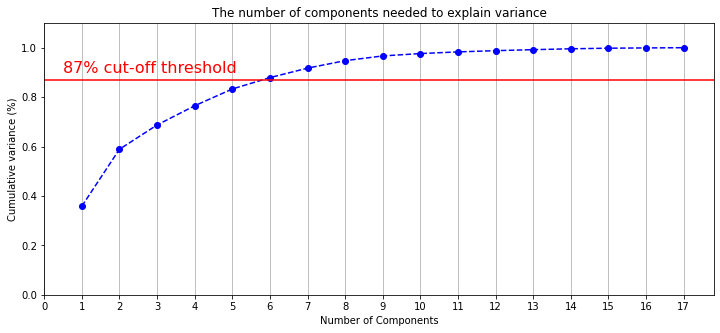

In [337]:
plt.rcParams["figure.figsize"] = (12,5)

fig, ax = plt.subplots()
xi = np.arange(1, 18, step=1)
y = np.cumsum(pca_scaled.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 18, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.87, color='r', linestyle='-')
plt.text(0.5, 0.9, '87% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

- EVR showed extreme drop from 1 to 3 then gradually from 3 to 10 with several rocky road. from 10 to 17 the graph moves smoothly.
- From the EVR cum, 87% cum EVR are showed at 6 components and 9 - 17 are rising slowly till 100%.
- The best cumulative EVR components are 7 - 9 because from 17 components cutting around 50% still provide a lot of information and the best from EVR are 6.

In [338]:
#improved PCA
pca_6 = PCA(n_components= 6)
pca_scale6 = pca_6.fit(df_scaled)


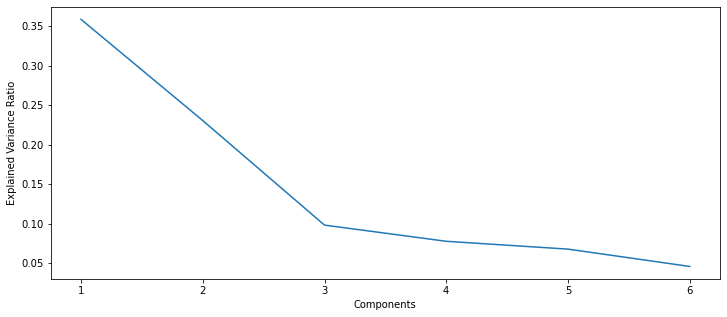

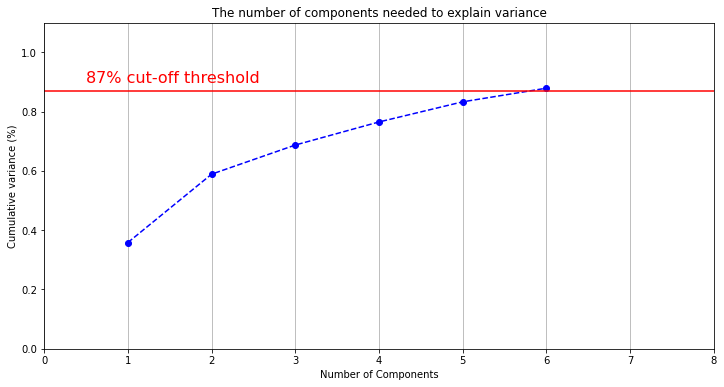

In [339]:
fig,ax=plt.subplots()
ax.plot(range(1,7),pca_scale6.explained_variance_ratio_)
ax.set_xlabel('Components')
ax.set_ylabel('Explained Variance Ratio')

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 7, step=1)
y = np.cumsum(pca_scale6.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 9, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.87, color='r', linestyle='-')
plt.text(0.5, 0.9, '87% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

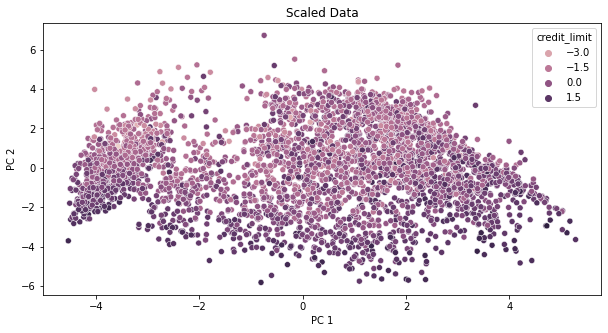

In [340]:
pca_2d=PCA(n_components=2).fit(df_scaled)
pca_2d_scaled=PCA(n_components=2).fit(df_scaled)

twod=pca_2d.transform(df_scaled)
twod_scaled=pca_2d_scaled.transform(df_scaled)

fig,ax=plt.subplots(figsize=(10,5))

sns.scatterplot(x=twod_scaled[:,0],y=twod_scaled[:,1],hue=df_scaled.credit_limit)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('Scaled Data')
plt.show()

2D model from PCA

In [341]:
df_pca = pca_6.transform(df_scaled)

In [342]:
df_pca = pd.DataFrame(df_pca, columns=["PC_1", "PC_2","PC_3","PC_4", "PC_5", "PC_6"])
df_pca

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,-3.310629,0.644290,0.484642,0.803973,-1.362026,0.530821
1,-0.369989,-0.763376,1.813777,-2.271918,-0.535080,1.170888
2,1.283890,-0.093517,-1.529106,-0.745228,-1.495335,1.090097
3,-0.663726,-1.589778,-2.663152,0.714860,0.354994,-0.749886
4,-3.182068,1.017286,-0.309030,-1.172570,-0.071364,-0.620382
...,...,...,...,...,...,...
3796,-3.041289,0.647469,-0.291691,-1.591360,-0.351286,-0.039199
3797,-1.421040,-0.383794,1.841591,1.915854,3.120440,0.446098
3798,3.612697,-2.025317,0.594767,-0.901233,0.394543,0.280991
3799,-3.178582,1.735592,-0.296049,-0.369458,1.934297,0.797232


In [343]:
#check multicollinearity between selected features engineering
s = df_pca[["PC_1", "PC_2","PC_3","PC_4", "PC_5","PC_6"]] #selected features engine

vif=pd.DataFrame()
vif['features'] = s.columns
vif['VIF'] = [variance_inflation_factor(s, i) for i in range(s.shape[1])]

vif

,features,VIF
0,PC_1,1.0
1,PC_2,1.0
2,PC_3,1.0
3,PC_4,1.0
4,PC_5,1.0
5,PC_6,1.0


No multicollinearity found after dimensional reduction

## VII. Model Definition & Training

In [344]:
cluster = [2,3,4,5,6]

In [345]:
#K-Means Model
kmeans_cluster = [KMeans(n_clusters = i, random_state = 1).fit (df_scaled) for i in cluster] 

In [346]:
#Agglomerative Clustering
agg = [AgglomerativeClustering(n_clusters = i, 
affinity = 'manhattan', linkage="complete").fit (df_scaled) for i in cluster]

In [347]:
#Gaussian Mixture Model
gm = [GaussianMixture(n_components=i, random_state=1).fit (df_scaled) for i in cluster]

## VIII. Model Evaluation

### K-Means

In [348]:
inertias = [model.inertia_ for model in kmeans_cluster]
inertias

[46805.541761208035,
 38552.534050388334,
 34120.202345812504,
 30709.949459220854,
 28939.670971883043]

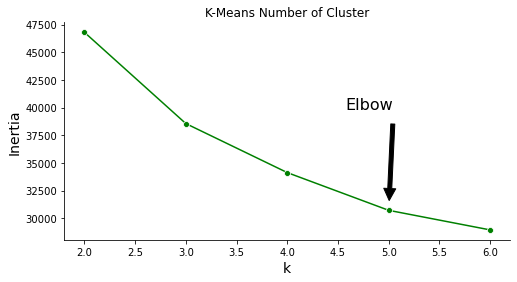

In [349]:
plt.figure(figsize=(8,4))
_ = sns.lineplot(x=[2,3,4,5,6], y=inertias, marker='o', color ='green')
_.set_xlabel('k', fontsize = 14)
_.set_ylabel('Inertia', fontsize = 14)
_.set_title('K-Means Number of Cluster')
plt.annotate('Elbow',xy=(5, inertias[3]), xytext=(0.6,0.6), textcoords= 'figure fraction',
fontsize = 16, arrowprops=dict(facecolor = 'black', shrink =0.1))

sns.despine()

In [350]:
silhouette_scores = [silhouette_score(df_scaled, model.labels_)
                     for model in kmeans_cluster]
silhouette_scores

[0.2634844466459149,
 0.24208287167177492,
 0.2346592727968664,
 0.24483054381177333,
 0.23589392327585296]

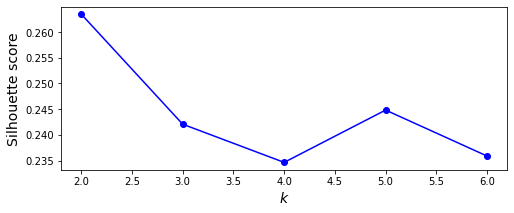

In [351]:
plt.figure(figsize=(8, 3))
plt.plot([2,3,4,5,6], silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

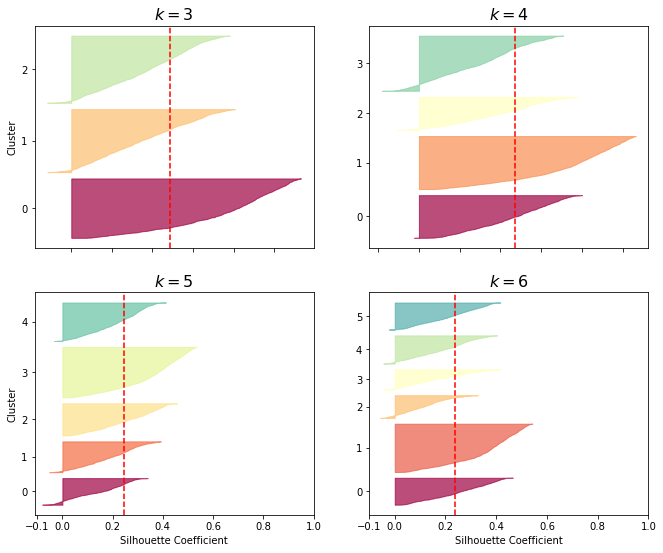

In [352]:
plt.figure(figsize=(11, 9))

for k in ( 3, 4, 5,6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_cluster[k-2].labels_
    silhouette_coefficients = silhouette_samples(df_scaled, y_pred)

    padding = len(df_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
plt.show()

From elbow method, the plot looks like an arm with elbow at k = 5 and based on silhouette score and graph the optimal k is 5. Optimal K for k-means is 5.

### Agglomerative Clustering

In [353]:
silhouette_scores_agg = [silhouette_score(df_scaled, model.labels_)
                     for model in agg]
silhouette_scores_agg

[0.24614580541256179,
 0.17872271249996768,
 0.12795647499908486,
 0.13438769021023841,
 0.14131296337378255]

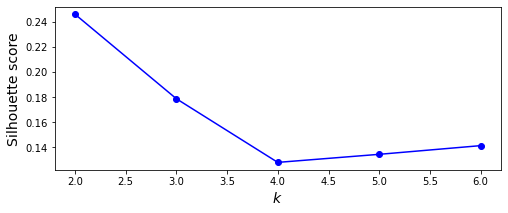

In [354]:
plt.figure(figsize=(8, 3))
plt.plot([2,3,4,5,6], silhouette_scores_agg, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

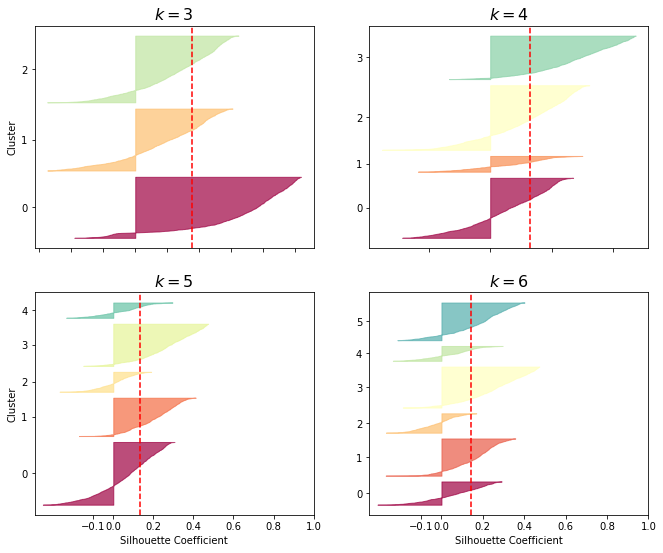

In [355]:
plt.figure(figsize=(11, 9))

for k in ( 3, 4, 5,6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = agg[k-2].labels_
    silhouette_coefficients = silhouette_samples(df_scaled, y_pred)

    padding = len(df_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores_agg[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
plt.show()

From silhouette score and graph, the best k is 6.

### Gaussian Mixture Model

In [356]:
# Get BIC and AIC Scores

bics = [model.bic(df_scaled) for model in gm]
aics = [model.aic(df_scaled) for model in gm]

for k in range(0, 5):
  print('Cluster : ', k+2, '\tBIC : ', bics[k], '\tAIC : ', aics[k])

Cluster :  2 	BIC :  39564.32123838776 	AIC :  37435.45159946243
Cluster :  3 	BIC :  -44564.33580001117 	AIC :  -47760.76176813366
Cluster :  4 	BIC :  -68925.52182877064 	AIC :  -73189.5041260903
Cluster :  5 	BIC :  -81372.59437185375 	AIC :  -86704.13299837057
Cluster :  6 	BIC :  -86526.9075816495 	AIC :  -92926.00253736349


BIC and AIC score inform cluster 6 is the best parameter for Gaussian Mixture Model.

### Plotting PCA vs Label

In [357]:
df_scaled

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,0.036663,-1.278539,-1.504763,-1.021813,-1.092513,1.067840,-1.281866,-0.918966,-1.012774,0.706547,0.847834,-1.389833,1.009163,0.447755,-0.622946,-0.685519,0.418457
1,1.257813,0.609338,0.841421,1.210522,-1.092513,-0.958086,-1.030873,-0.117066,-1.012774,-0.893049,-0.917333,-0.885836,0.722770,0.082976,1.108268,-0.685519,0.418457
2,0.671190,0.609338,-0.222937,-1.021813,0.501775,-0.958086,0.849770,-0.918966,1.047710,-0.893049,-0.917333,0.345588,0.722770,0.959961,0.208713,0.383701,0.418457
3,0.608379,0.609338,0.380966,-1.021813,0.971756,1.128304,0.849770,-0.918966,1.164681,1.695008,1.468686,0.345588,-0.139759,-0.037972,0.220443,-0.685519,0.418457
4,0.406623,0.609338,-1.504763,-1.021813,-1.092513,1.094650,-1.281866,-0.918966,-1.012774,0.101437,0.159021,-1.389833,-0.962685,-0.757225,-0.101868,-0.685519,0.418457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,0.673641,0.609338,-1.504763,-1.021813,-1.092513,0.280416,-1.281866,-0.918966,-1.012774,0.101437,0.159021,-1.389833,-0.625837,-0.551009,0.692937,-0.685519,0.418457
3797,0.347228,-1.681805,0.404800,0.991155,-1.092513,1.118551,-0.094526,1.258075,-1.012774,1.207214,1.218287,0.201231,-0.359985,-1.096660,-0.233925,-0.685519,-2.553911
3798,0.527482,0.609338,1.641097,1.482139,1.119002,-0.958086,1.203440,1.729467,1.164681,-0.893049,-0.917333,1.471242,0.491958,0.933554,0.301553,-0.685519,0.418457
3799,0.241379,0.609338,-1.504763,-1.021813,-1.092513,0.401377,-1.281866,-0.918966,-1.012774,0.246762,0.159021,-1.389833,-1.219457,-1.151439,-0.288669,-0.685519,-2.460129


In [358]:
k_means5 = kmeans_cluster[3].predict(df_scaled)
agg6 = agg[4].fit_predict(df_scaled)
gm6 = gm[4].predict(df_scaled)

In [359]:
df_pca['kmeans5'] = k_means5
df_pca['agg6'] = agg6
df_pca['gm6'] = gm6
df_pca

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,kmeans5,agg6,gm6
0,-3.310629,0.644290,0.484642,0.803973,-1.362026,0.530821,3,3,0
1,-0.369989,-0.763376,1.813777,-2.271918,-0.535080,1.170888,0,0,5
2,1.283890,-0.093517,-1.529106,-0.745228,-1.495335,1.090097,4,1,4
3,-0.663726,-1.589778,-2.663152,0.714860,0.354994,-0.749886,1,2,1
4,-3.182068,1.017286,-0.309030,-1.172570,-0.071364,-0.620382,3,4,0
...,...,...,...,...,...,...,...,...,...
3796,-3.041289,0.647469,-0.291691,-1.591360,-0.351286,-0.039199,3,3,0
3797,-1.421040,-0.383794,1.841591,1.915854,3.120440,0.446098,0,2,1
3798,3.612697,-2.025317,0.594767,-0.901233,0.394543,0.280991,2,5,3
3799,-3.178582,1.735592,-0.296049,-0.369458,1.934297,0.797232,3,4,0


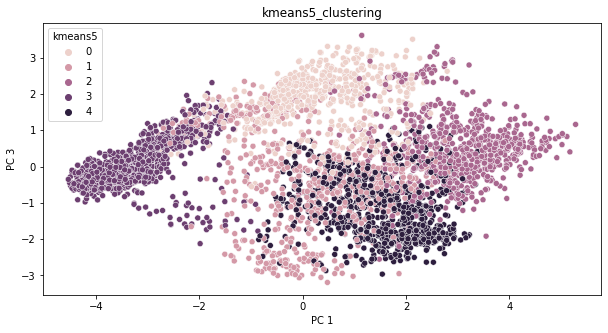

In [360]:
fig,ax=plt.subplots(figsize=(10,5))

sns.scatterplot(x=df_pca['PC_1'],y=df_pca['PC_3'],hue=df_pca.kmeans5)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 3')
ax.set_title('kmeans5_clustering')
plt.show()

From the model, it is better to use only 4 clusters for k-means model.

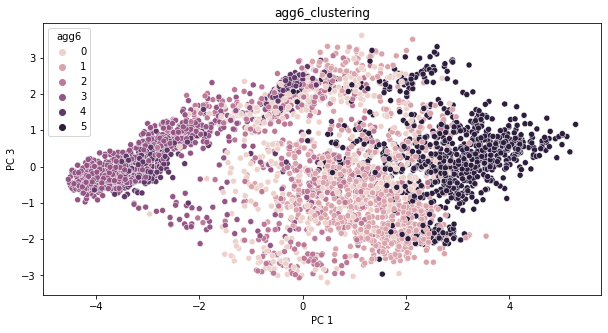

In [361]:
fig,ax=plt.subplots(figsize=(10,5))

sns.scatterplot(x=df_pca['PC_1'],y=df_pca['PC_3'],hue=df_pca.agg6)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 3')
ax.set_title('agg6_clustering')
plt.show()

From the model, it is better to use only 4 clusters for agglomerative model, because each cluster is hard to differentiate.

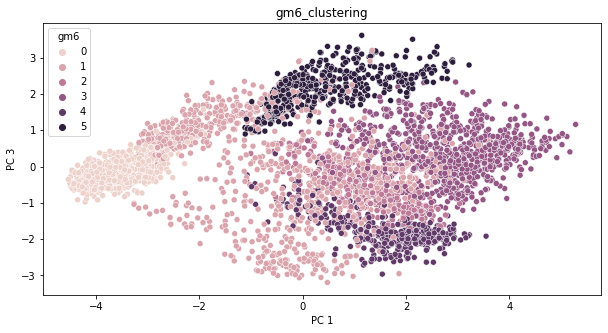

In [362]:
fig,ax=plt.subplots(figsize=(10,5))

sns.scatterplot(x=df_pca['PC_1'],y=df_pca['PC_3'],hue=df_pca.gm6)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 3')
ax.set_title('gm6_clustering')
plt.show()

From the model, gaussian mixture model has better performance because it is easier to differentiate each cluster from each other, although mostly cluster 1, 2, and 4 are mixed. 

### EDA Model

In [363]:
train.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
3723,6265,764.042156,0.818182,0.00,0.00,0.0,1307.102516,0.000000,0.000000,0.000000,0.166667,3,0,7500.0,1566.806897,172.959728,0.000000,12
1125,579,4181.216991,1.000000,1443.33,1443.33,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,6000.0,1027.149996,1420.666789,0.000000,12
2000,4909,1981.929376,1.000000,145.80,0.00,145.8,0.000000,0.833333,0.000000,0.750000,0.000000,0,10,6000.0,2803.926679,467.477726,0.083333,12
4085,1861,1817.150299,1.000000,596.50,0.00,596.5,1736.759805,0.833333,0.000000,0.833333,0.583333,11,10,3000.0,891.637597,474.182947,0.000000,12
2811,1941,1360.742377,1.000000,0.00,0.00,0.0,1481.587093,0.000000,0.000000,0.000000,0.083333,1,0,1500.0,378.294227,321.354137,0.000000,12


In [364]:
df_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,kmeans5,agg6,gm6
0,-3.310629,0.644290,0.484642,0.803973,-1.362026,0.530821,3,3,0
1,-0.369989,-0.763376,1.813777,-2.271918,-0.535080,1.170888,0,0,5
2,1.283890,-0.093517,-1.529106,-0.745228,-1.495335,1.090097,4,1,4
3,-0.663726,-1.589778,-2.663152,0.714860,0.354994,-0.749886,1,2,1
4,-3.182068,1.017286,-0.309030,-1.172570,-0.071364,-0.620382,3,4,0


In [365]:
train1 = train.copy()

In [366]:
cust = train1.pop('cust_id')
cust

3723    6265
1125     579
2000    4909
4085    1861
2811    1941
        ... 
2895    4931
2763    1611
905     7043
3980    4011
235     1075
Name: cust_id, Length: 3801, dtype: int64

In [367]:
cust.reset_index(drop=True, inplace=True)

In [368]:
df_pca.reset_index(drop=True, inplace=True)

In [369]:
df_pca_final = pd.concat([cust, df_pca], axis = 1)
df_pca_final

,cust_id,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,kmeans5,agg6,gm6
0,6265,-3.310629,0.644290,0.484642,0.803973,-1.362026,0.530821,3,3,0
1,579,-0.369989,-0.763376,1.813777,-2.271918,-0.535080,1.170888,0,0,5
2,4909,1.283890,-0.093517,-1.529106,-0.745228,-1.495335,1.090097,4,1,4
3,1861,-0.663726,-1.589778,-2.663152,0.714860,0.354994,-0.749886,1,2,1
4,1941,-3.182068,1.017286,-0.309030,-1.172570,-0.071364,-0.620382,3,4,0
...,...,...,...,...,...,...,...,...,...,...
3796,4931,-3.041289,0.647469,-0.291691,-1.591360,-0.351286,-0.039199,3,3,0
3797,1611,-1.421040,-0.383794,1.841591,1.915854,3.120440,0.446098,0,2,1
3798,7043,3.612697,-2.025317,0.594767,-0.901233,0.394543,0.280991,2,5,3
3799,4011,-3.178582,1.735592,-0.296049,-0.369458,1.934297,0.797232,3,4,0


In [370]:
# Merging the df with PCA with train data
df_merge = pd.merge(train,df_pca_final,on='cust_id')
df_merge

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,...,tenure,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,kmeans5,agg6,gm6
0,6265,764.042156,0.818182,0.00,0.00,0.0,1307.102516,0.000000,0.000000,0.000000,...,12,-3.310629,0.644290,0.484642,0.803973,-1.362026,0.530821,3,3,0
1,579,4181.216991,1.000000,1443.33,1443.33,0.0,0.000000,0.083333,0.083333,0.000000,...,12,-0.369989,-0.763376,1.813777,-2.271918,-0.535080,1.170888,0,0,5
2,4909,1981.929376,1.000000,145.80,0.00,145.8,0.000000,0.833333,0.000000,0.750000,...,12,1.283890,-0.093517,-1.529106,-0.745228,-1.495335,1.090097,4,1,4
3,1861,1817.150299,1.000000,596.50,0.00,596.5,1736.759805,0.833333,0.000000,0.833333,...,12,-0.663726,-1.589778,-2.663152,0.714860,0.354994,-0.749886,1,2,1
4,1941,1360.742377,1.000000,0.00,0.00,0.0,1481.587093,0.000000,0.000000,0.000000,...,12,-3.182068,1.017286,-0.309030,-1.172570,-0.071364,-0.620382,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,4931,1988.595057,1.000000,0.00,0.00,0.0,49.912460,0.000000,0.000000,0.000000,...,12,-3.041289,0.647469,-0.291691,-1.591360,-0.351286,-0.039199,3,3,0
3797,1611,1245.654818,0.714286,626.56,626.56,0.0,1658.285219,0.428571,0.428571,0.000000,...,7,-1.421040,-0.383794,1.841591,1.915854,3.120440,0.446098,0,2,1
3798,7043,1621.345326,1.000000,5167.60,4246.50,921.1,0.000000,1.000000,1.000000,0.833333,...,12,3.612697,-2.025317,0.594767,-0.901233,0.394543,0.280991,2,5,3
3799,4011,1060.010246,1.000000,0.00,0.00,0.0,78.971459,0.000000,0.000000,0.000000,...,10,-3.178582,1.735592,-0.296049,-0.369458,1.934297,0.797232,3,4,0


In [371]:
df_merge_col = df_merge.drop(columns = ["PC_1", "PC_2","PC_3","PC_4", "PC_5", "PC_6"])

<AxesSubplot:xlabel='kmeans5', ylabel='purchases'>

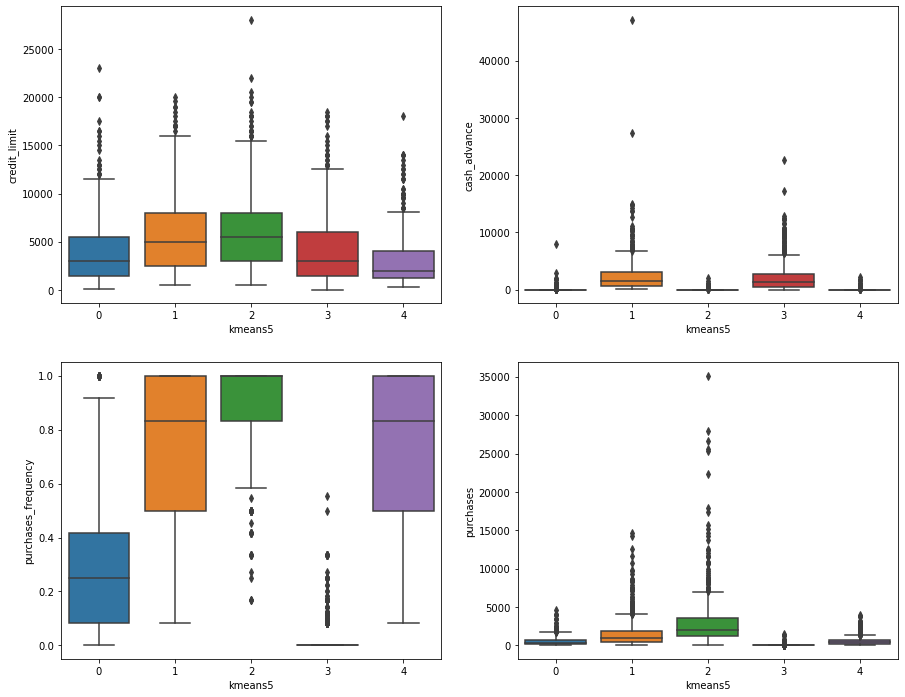

In [372]:
fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.boxplot(x = 'kmeans5', y = 'credit_limit', data = df_merge_col,ax=axes[0][0])
sns.boxplot(x = 'kmeans5', y = 'cash_advance', data = df_merge_col,ax=axes[0][1])
sns.boxplot(x = 'kmeans5', y = 'purchases_frequency', data=df_merge_col,ax=axes[1][0])
sns.boxplot(x = 'kmeans5', y = 'purchases', data=df_merge_col,ax=axes[1][1])

From k-means clustering, credit limit 

<AxesSubplot:xlabel='agg6', ylabel='purchases'>

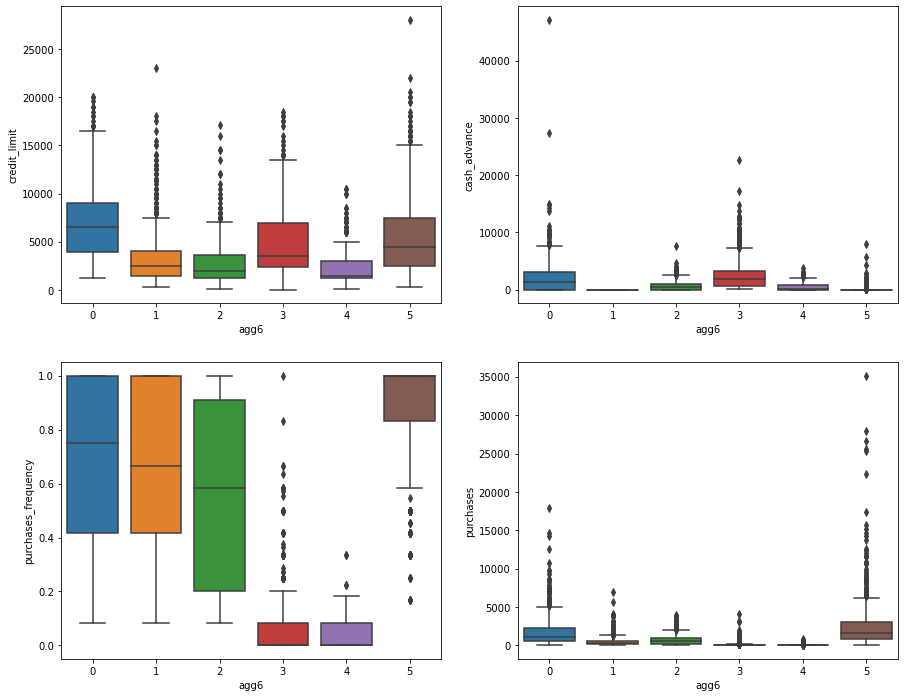

In [373]:
fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.boxplot(x = 'agg6', y = 'credit_limit', data = df_merge_col,ax=axes[0][0])
sns.boxplot(x = 'agg6', y = 'cash_advance', data = df_merge_col,ax=axes[0][1])
sns.boxplot(x = 'agg6', y = 'purchases_frequency', data=df_merge_col,ax=axes[1][0])
sns.boxplot(x = 'agg6', y = 'purchases', data=df_merge_col,ax=axes[1][1])

<AxesSubplot:xlabel='gm6', ylabel='purchases'>

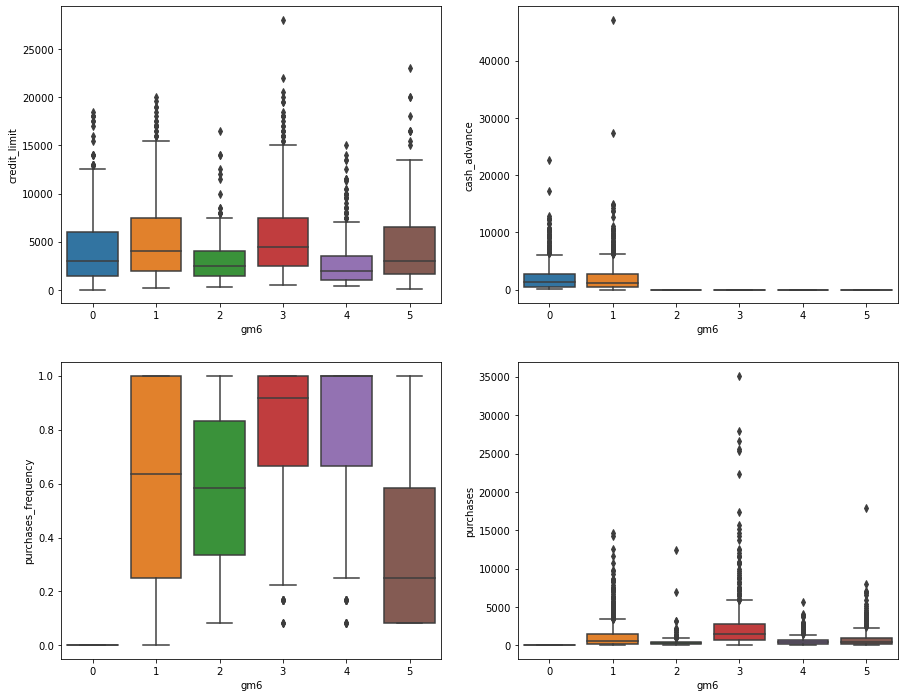

In [374]:
fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.boxplot(x = 'gm6', y = 'credit_limit', data = df_merge_col,ax=axes[0][0])
sns.boxplot(x = 'gm6', y = 'cash_advance', data = df_merge_col,ax=axes[0][1])
sns.boxplot(x = 'gm6', y = 'purchases_frequency', data=df_merge_col,ax=axes[1][0])
sns.boxplot(x = 'gm6', y = 'purchases', data=df_merge_col,ax=axes[1][1])

## X. Model Inference

### a. Create Data Inference

In [375]:
inf

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
2756,6671,435.696854,1.000000,0.00,0.00,0.00,460.284824,0.000000,0.000000,0.000000,0.285714,4,0,500.0,70.419023,153.993517,0.000,7
2815,2095,960.221148,0.727273,0.00,0.00,0.00,1357.652469,0.000000,0.000000,0.000000,0.083333,3,0,1500.0,308.039409,373.610849,0.000,12
1781,7389,4.392146,0.181818,47.96,0.00,47.96,0.000000,0.166667,0.000000,0.166667,0.000000,0,4,3000.0,250.202110,87.580114,0.000,12
3774,167,10359.454710,1.000000,12650.00,12650.00,0.00,2781.682203,0.250000,0.250000,0.000000,0.166667,2,10,10500.0,7566.470234,9170.428051,0.000,12
2388,539,1403.597712,1.000000,1050.83,67.90,982.93,4083.515108,1.000000,0.083333,1.000000,0.250000,4,24,5000.0,4673.520993,982.544984,0.000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,2175,1256.034535,1.000000,545.74,110.00,435.74,381.203187,0.583333,0.166667,0.500000,0.166667,2,9,7000.0,561.983691,294.602332,0.000,12
2379,7449,5926.922151,1.000000,2325.75,2325.75,0.00,461.862131,0.500000,0.500000,0.000000,0.250000,3,25,13000.0,1489.518098,1644.757535,0.000,12
1144,1763,8.576818,0.181818,80.00,80.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,7500.0,76.188977,14.667507,0.000,12
1614,5107,21.718289,1.000000,182.27,0.00,182.27,0.000000,0.916667,0.000000,0.833333,0.000000,0,11,1500.0,176.130076,171.217707,0.375,12


In [380]:
agg_inf = AgglomerativeClustering(n_clusters = 6, affinity = 'manhattan', linkage="complete").fit_predict(inf) 

In [382]:
inf['agg6'] = agg_inf

In [388]:
inf

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,agg6
2756,6671,435.696854,1.000000,0.00,0.00,0.00,460.284824,0.000000,0.000000,0.000000,0.285714,4,0,500.0,70.419023,153.993517,0.000,7,0
2815,2095,960.221148,0.727273,0.00,0.00,0.00,1357.652469,0.000000,0.000000,0.000000,0.083333,3,0,1500.0,308.039409,373.610849,0.000,12,0
1781,7389,4.392146,0.181818,47.96,0.00,47.96,0.000000,0.166667,0.000000,0.166667,0.000000,0,4,3000.0,250.202110,87.580114,0.000,12,0
3774,167,10359.454710,1.000000,12650.00,12650.00,0.00,2781.682203,0.250000,0.250000,0.000000,0.166667,2,10,10500.0,7566.470234,9170.428051,0.000,12,4
2388,539,1403.597712,1.000000,1050.83,67.90,982.93,4083.515108,1.000000,0.083333,1.000000,0.250000,4,24,5000.0,4673.520993,982.544984,0.000,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,2175,1256.034535,1.000000,545.74,110.00,435.74,381.203187,0.583333,0.166667,0.500000,0.166667,2,9,7000.0,561.983691,294.602332,0.000,12,0
2379,7449,5926.922151,1.000000,2325.75,2325.75,0.00,461.862131,0.500000,0.500000,0.000000,0.250000,3,25,13000.0,1489.518098,1644.757535,0.000,12,0
1144,1763,8.576818,0.181818,80.00,80.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,7500.0,76.188977,14.667507,0.000,12,0
1614,5107,21.718289,1.000000,182.27,0.00,182.27,0.000000,0.916667,0.000000,0.833333,0.000000,0,11,1500.0,176.130076,171.217707,0.375,12,0


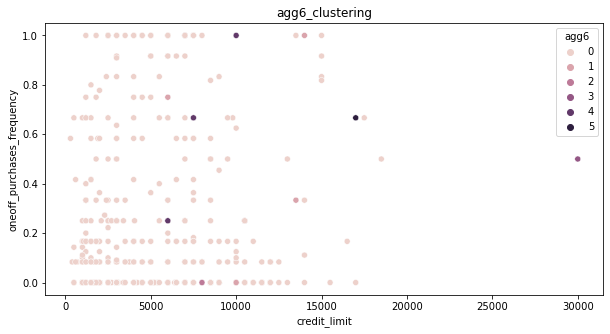

In [391]:
fig,ax=plt.subplots(figsize=(10,5))

sns.scatterplot(x=inf['credit_limit'],y=inf['oneoff_purchases_frequency'],hue=inf.agg6)
ax.set_xlabel('credit_limit')
ax.set_ylabel('oneoff_purchases_frequency')
ax.set_title('agg6_clustering')
plt.show()

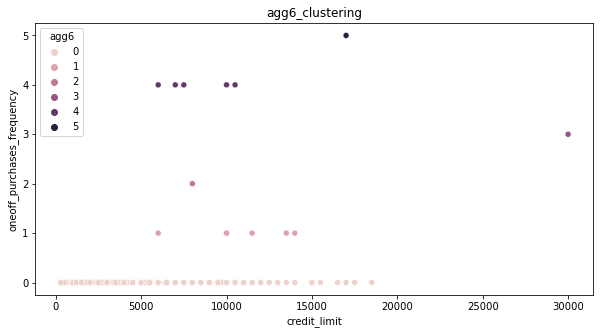

In [394]:
fig,ax=plt.subplots(figsize=(10,5))

sns.scatterplot(x=inf['credit_limit'],y=inf['agg6'], hue=inf.agg6)
ax.set_xlabel('credit_limit')
ax.set_ylabel('oneoff_purchases_frequency')
ax.set_title('agg6_clustering')
plt.show()

## XI. Conclusion

The dataset talks about heart failure death patients with several cause from anaemia, diabetes, ejection fraction, etc. The patients are from 40 years old - 95 years old with total 96 people are dead because of heart failure. There are 194 man and 105 woman. Most of the death patients are 60 years old, total patients >= 60 years old death are 65 people and 31 people die when <60 years old.

Based from the model performance and analysis, it is better to use XGBoost to predict death patients probability. To improve XGBoost model, it is suggested to add the another feature engineer or tune XGBoost hyperparameter hoping for better recall score.

### Conceptual Problems
1. What is inertia in K-Means algorithm?
2. Explain about Elbow Method (why use Elbow method, how to use, advantage/disadvantage)!
3. Explain difference about each clustering algorithm used in this case!

Answers:

1. Inertia is a measurement for k-means to identify how well the data clustered.
    - https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet

2. Elbow method is used because it is needed to find optimal K through plotting inertia vs number of clusters (k). How to use: Find the point in the graph where after extreme decrease in graph slow down. Advantage: Elbow method is easier to calculated. Disadvantages: Compared to silhouette score, elbow method can't presented outiers in cluster and ambiguity arised to pick the value of k.
    - https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet
    - https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891

3. - K-Means:is a repetitive algorithm aim to seperate dataset into Kpre-defined distinct with no overlapping cluster and data in each cluster.
    - Gaussian Mixture Model: is a model which comprised of several Gaussians function, each function is identified by k ∈ {1,…, K},where K is number of group in the dataset. 
    - Agglomerative Clustering: is a model where each cluster are ranked.
    - https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
    - https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95
    - https://towardsdatascience.com/agglomerative-clustering-and-dendrograms-explained-29fc12b85f23#:~:text=Agglomerative%20Clustering%20is%20a%20type,in%20different%20clusters%20are%20dissimilar.
